In [1]:
import arviz as az
import bambi as bmb
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from causalgraphicalmodels import CausalGraphicalModel
from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
az.style.use("arviz-darkgrid")
np.random.seed(1211)

#### Code 5.1

We first need to define the function that is going to standardize numeric variables.

In [3]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

In [4]:
d = pd.read_csv("data/WaffleDivorce.csv")
d["D"] = standardize(d["Divorce"])
d["M"] = standardize(d["Marriage"])
d["A"] = standardize(d["MedianAgeMarriage"])

#### Code 5.2

In [5]:
np.std(d["MedianAgeMarriage"])

1.231131187160816

#### Coce 5.3

In [6]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "A": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_1 = bmb.Model("D ~ A", d, priors=priors)
results_5_1 = model_5_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, A, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


#### Code 5.4

We call `.prior_predictive()` on the model object and take the prior samples from the InferenceData object returned.

In [7]:
prior_predictive = model_5_1.prior_predictive().prior
a = prior_predictive["Intercept"].values.flatten()
bA = prior_predictive["A"].values.flatten()

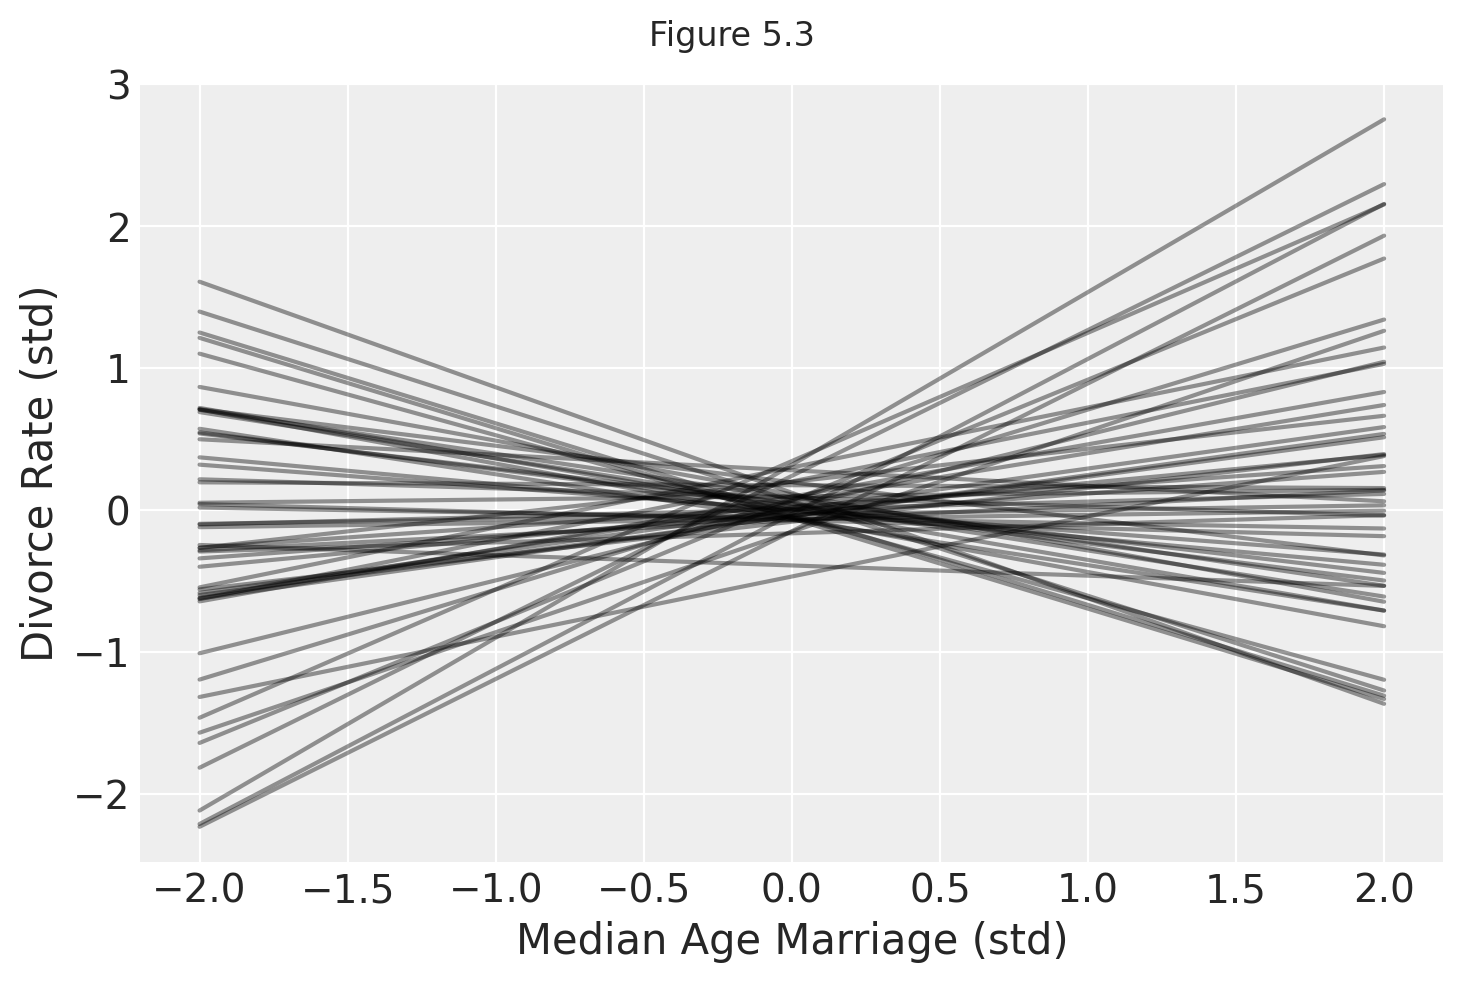

In [8]:

fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(a[:50], bA[:50]):
    ax.plot(x, a + ba * x, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

#### Code 5.5

In [9]:
A_seq = np.linspace(-3, 3.2, 30)
a = results_5_1.posterior["Intercept"].values.flatten()
bA = results_5_1.posterior["A"].values.flatten()
mu_pred = np.zeros((len(A_seq), len(a)))

for i, age in enumerate(A_seq):
    mu_pred[i] = a + bA * age

mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

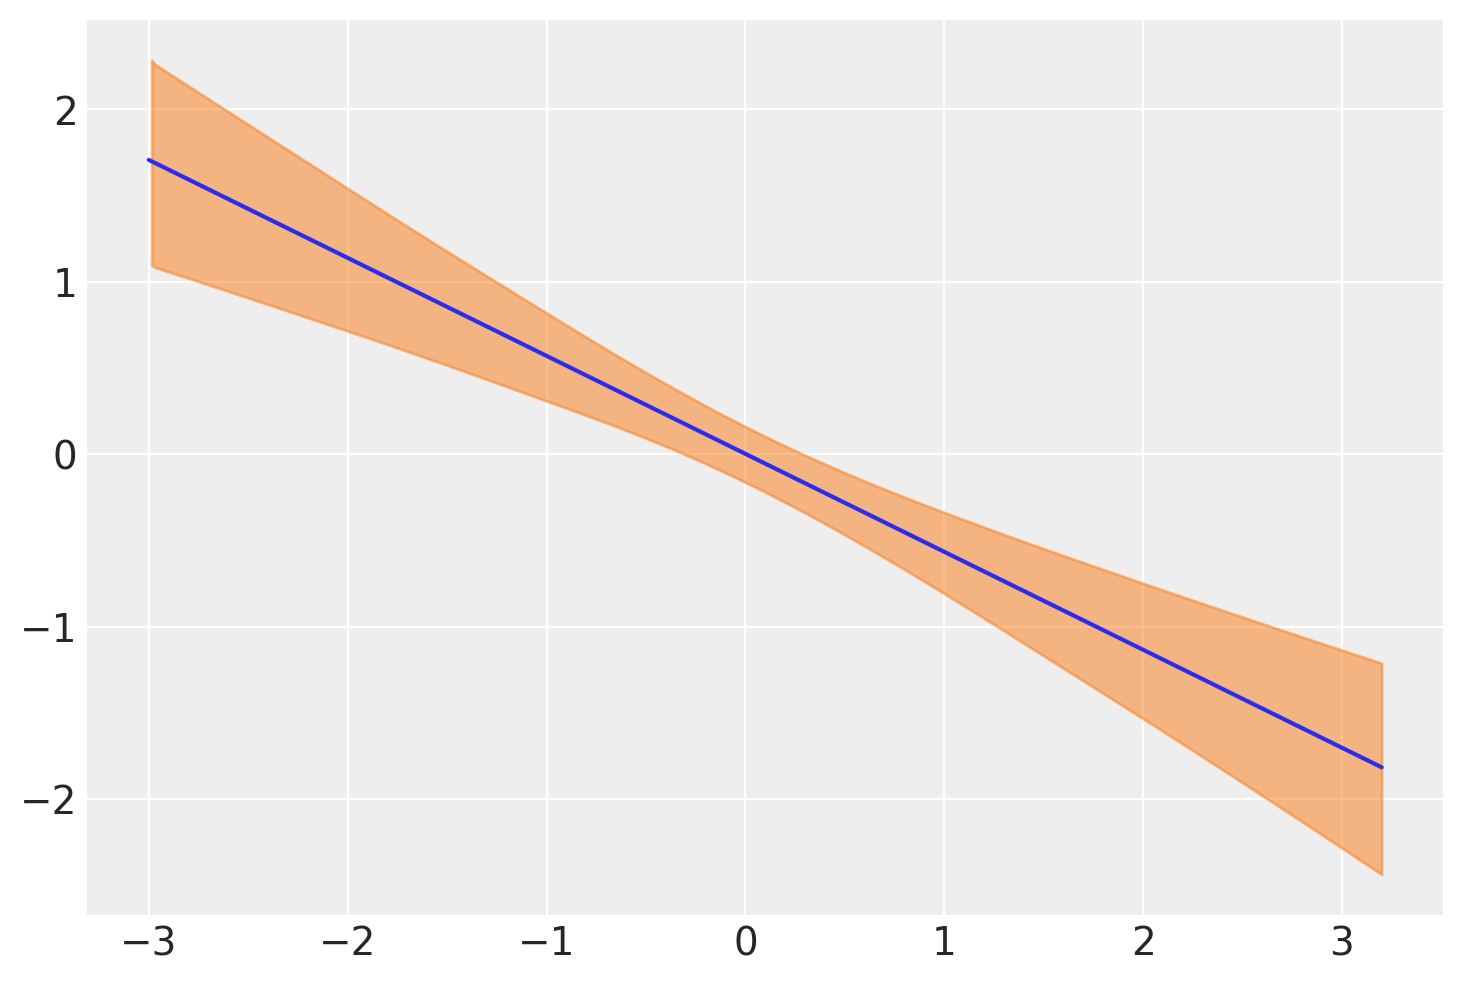

In [10]:
az.plot_hdi(A_seq, hdi_data=mu_PI)
plt.plot(A_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

In the previous call to `az.plot_hdi()` we have passed the `mu_PI` array we've manually computed to mimic the original code in the book. However, we could have just used `az.plot_hdi(A_seq, mu_pred.T)` and ArviZ would compute the interval for us.

#### Code 5.6

In [11]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "M": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_2 = bmb.Model("D ~ M", d, priors=priors)
results_5_2 = model_5_2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, M, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 5.7

Add something here such as credits to original author

/home/tomas/anaconda3/envs/bmbrsrc/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


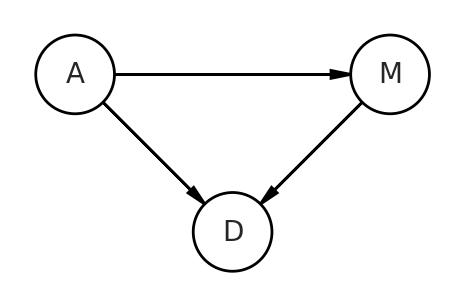

In [12]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

#### Code 5.8

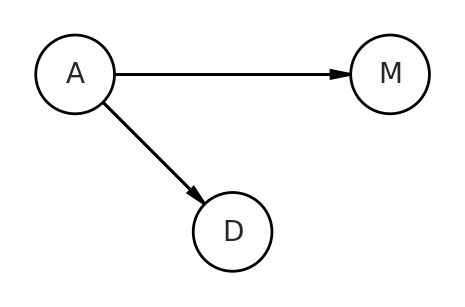

In [13]:
dag5_2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [14]:
print(dag5_2.get_distribution())


P(A)P(M|A)P(D|A)


In [15]:
dag5_2.get_all_independence_relationships()

[('D', 'M', {'A'})]

In [16]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


#### Code 5.9

There are no conditional independencies, so there is no output to display.

In [17]:
DMA_dag1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

#### Code 5.10

In [18]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "M": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "A": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_3 = bmb.Model("D ~ M + A", d, priors=priors)
results_5_3 = model_5_3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D_sigma, A, M, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [19]:
az.summary(results_5_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-0.001,0.101,-0.189,0.188
M,-0.061,0.164,-0.370,0.236
A,-0.611,0.160,-0.902,-0.313
D_sigma,0.838,0.088,0.678,0.998


#### Code 5.11

There's so much space in the plot, see if it is possible to reduce it.

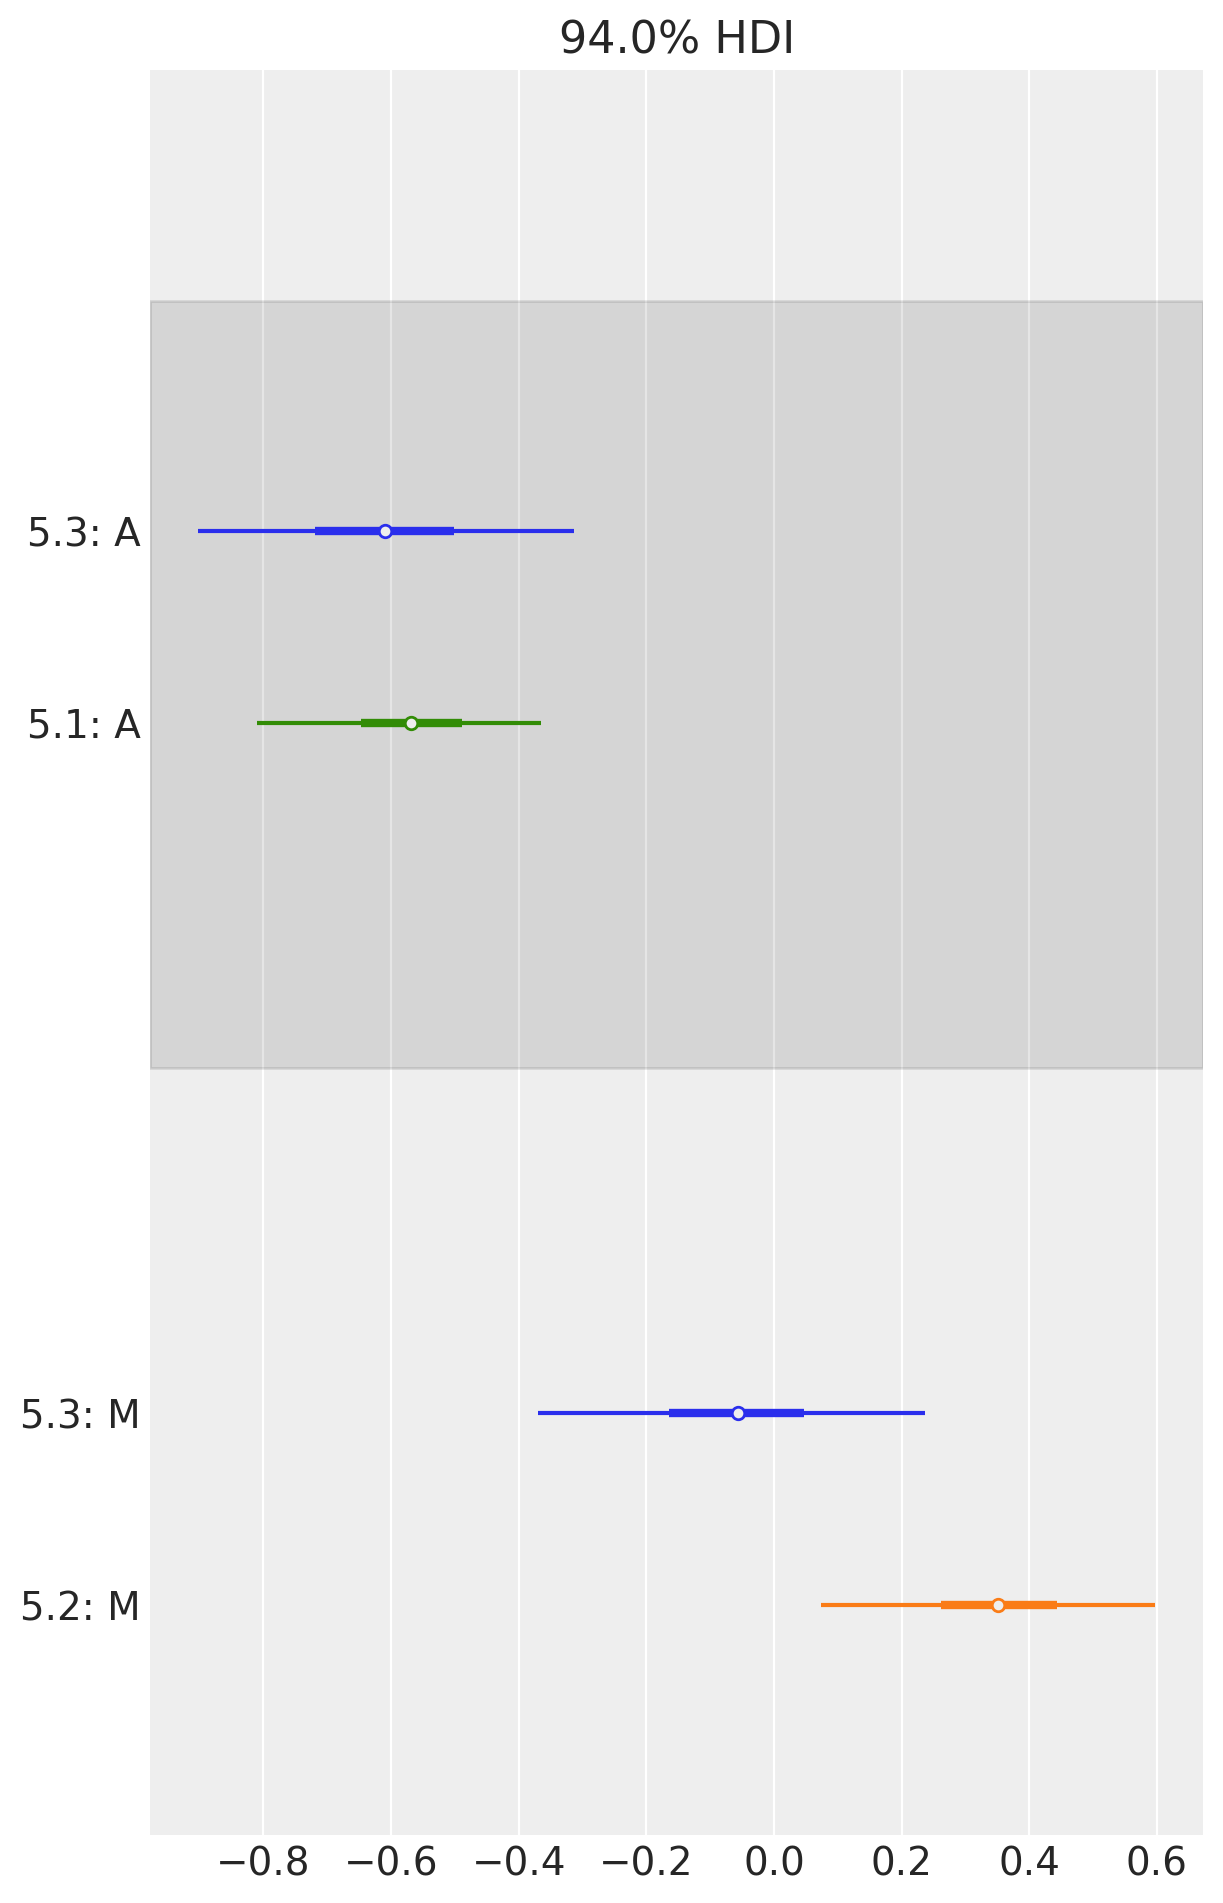

In [20]:
az.plot_forest(
    [
        results_5_3,
        results_5_2,
        results_5_1,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["A", "M"],
    combined=True,
);

#### Code 5.12

In [ ]:
N = 50
age = stats.norm().rvs(N)     # sim A
mar = stats.norm(-age).rvs(N) # sim A -> M
div = stats.norm(age).rvs(N)  # sim A -> D

#### Code 5.13

Note we use one predictor to predict the other. In this first model we use `A` to predict `M`.

In [22]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sd=0.2), # dnorm(0, 0.2)
    "A": bmb.Prior("Normal", mu=0, sd=0.5),         # dnorm(0, 0.5)
    "sigma": bmb.Prior("Exponential", lam=1),       # sigma ~ dexp(1)
}

model_5_4 = bmb.Model("M ~ A", d, priors=priors)
results_5_4 = model_5_4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [M_sigma, A, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 5.14

Here we use the observed values of `A` to predict the values of `M`. Then we subtract this prediction (the mean) from the observed values of `M` and we get the residuals. These residuals are the segments in the top left panel in Figure 5.4 in the book.

In [29]:
A_seq = d["A"]
a = results_5_4.posterior["Intercept"].values.flatten()
bA = results_5_4.posterior["A"].values.flatten()
mu_pred = np.zeros((len(A_seq), len(a)))

for i, age in enumerate(A_seq):
    mu_pred[i] = a + bA * age

mu_mean = mu_pred.mean(1)
mu_resid = d["M"] - mu_mean

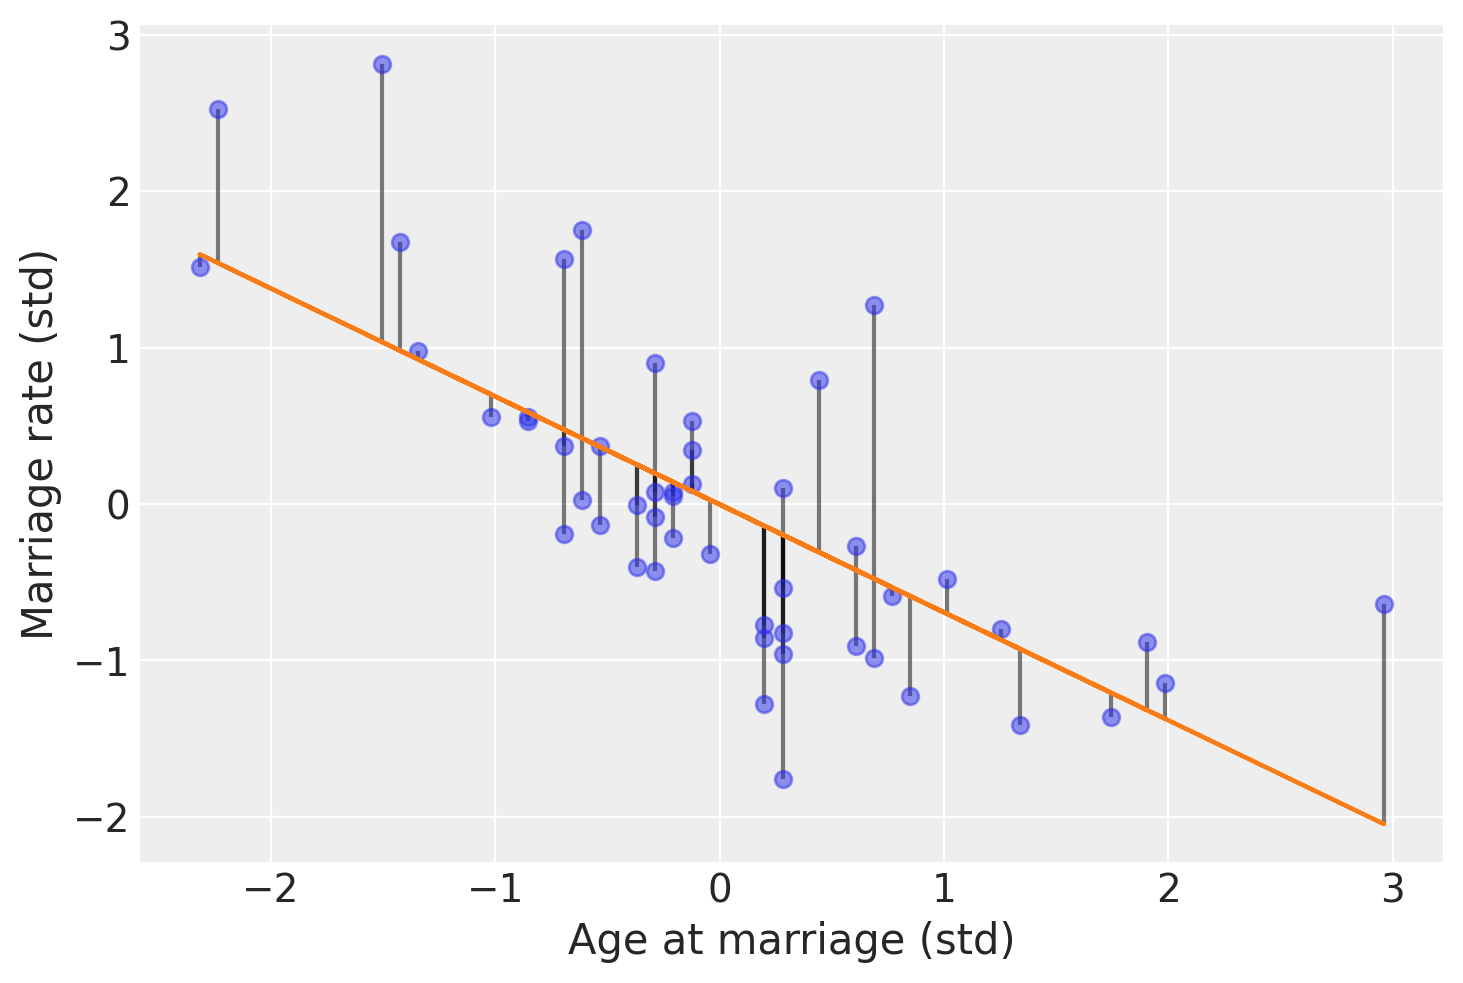

In [46]:
plt.plot(d["A"], d["M"], "o", alpha=0.5)
plt.vlines(d["A"], ymin=mu_mean, ymax=d["M"], color="black", alpha=0.5)
plt.plot(d["A"], mu_mean)
plt.xlabel("Age at marriage (std)")
plt.ylabel("Marriage rate (std)");

#### Code 5.15

In [48]:
model_5_3

Formula: D ~ M + A
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Intercept ~ Normal(mu: 0, sd: 0.2)
  M ~ Normal(mu: 0, sd: 0.5)
  A ~ Normal(mu: 0, sd: 0.5)
  sigma ~ Exponential(lam: 1)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [55]:
a = results_5_3.posterior["Intercept"].values.flatten()
bM = results_5_3.posterior["M"].values.flatten()
bA = results_5_3.posterior["A"].values.flatten()
mu_pred = np.zeros((d.shape[0], len(a))) # data.shape[0] equals number of observations

for i in range(d.shape[0]):
    mu_pred[i] = a + bM * d["M"][i] + bA * d["A"][i]

mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

In [72]:
# Here we use the original data
model_5_3.posterior_predictive(results_5_3, 1000)

/home/tomas/anaconda3/envs/bmbrsrc/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [69]:
D_sim = results_5_3.posterior_predictive["D"].mean(axis=0).values
D_PI = np.quantile(D_sim, [0.05, 0.94], axis=1).T

#### Code 5.16

In [ ]:
plt.

In [78]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    d["D"],
    mu_PI,
    yerr=np.abs(mu_PI - mu_PI),
    fmt="C0o",
)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

ValueError: too many values to unpack (expected 1)

In [83]:
x

[-1.99055341465513, 2.114824307877746]

In [88]:
mu_PI[:,0]

array([ 1.42859706e-01, -3.78302271e-02, -5.27606441e-02,  4.04069583e-01,
       -5.68692495e-01, -1.42063655e-01, -1.01535714e+00, -6.53458081e-01,
       -2.46648931e+00, -3.60306385e-01, -1.66302585e-01, -9.92725062e-01,
        8.51815369e-01, -6.60736083e-01, -7.18368759e-03,  1.00367013e-01,
        2.50463533e-01,  3.26292252e-01, -1.03324800e-01, -5.01948994e-01,
       -8.56302378e-01, -1.56673750e+00, -3.74703205e-01, -3.84706066e-01,
       -5.54521026e-02,  1.28614984e-03, -3.43860048e-02,  1.00231852e-01,
       -5.59207110e-01, -1.06868736e+00, -5.30237972e-02, -1.53299709e+00,
       -1.17727021e-02, -1.44544467e-01, -3.20809050e-01,  4.57847414e-01,
       -1.43705091e-01, -7.24944874e-01, -1.36649095e+00, -3.36085528e-01,
        3.18746926e-02,  1.58904393e-01,  1.78309931e-01,  6.87073927e-01,
       -6.11136998e-01, -3.71108826e-01, -1.30879044e-01,  2.50934790e-01,
       -3.09043918e-01,  1.61095603e-01])

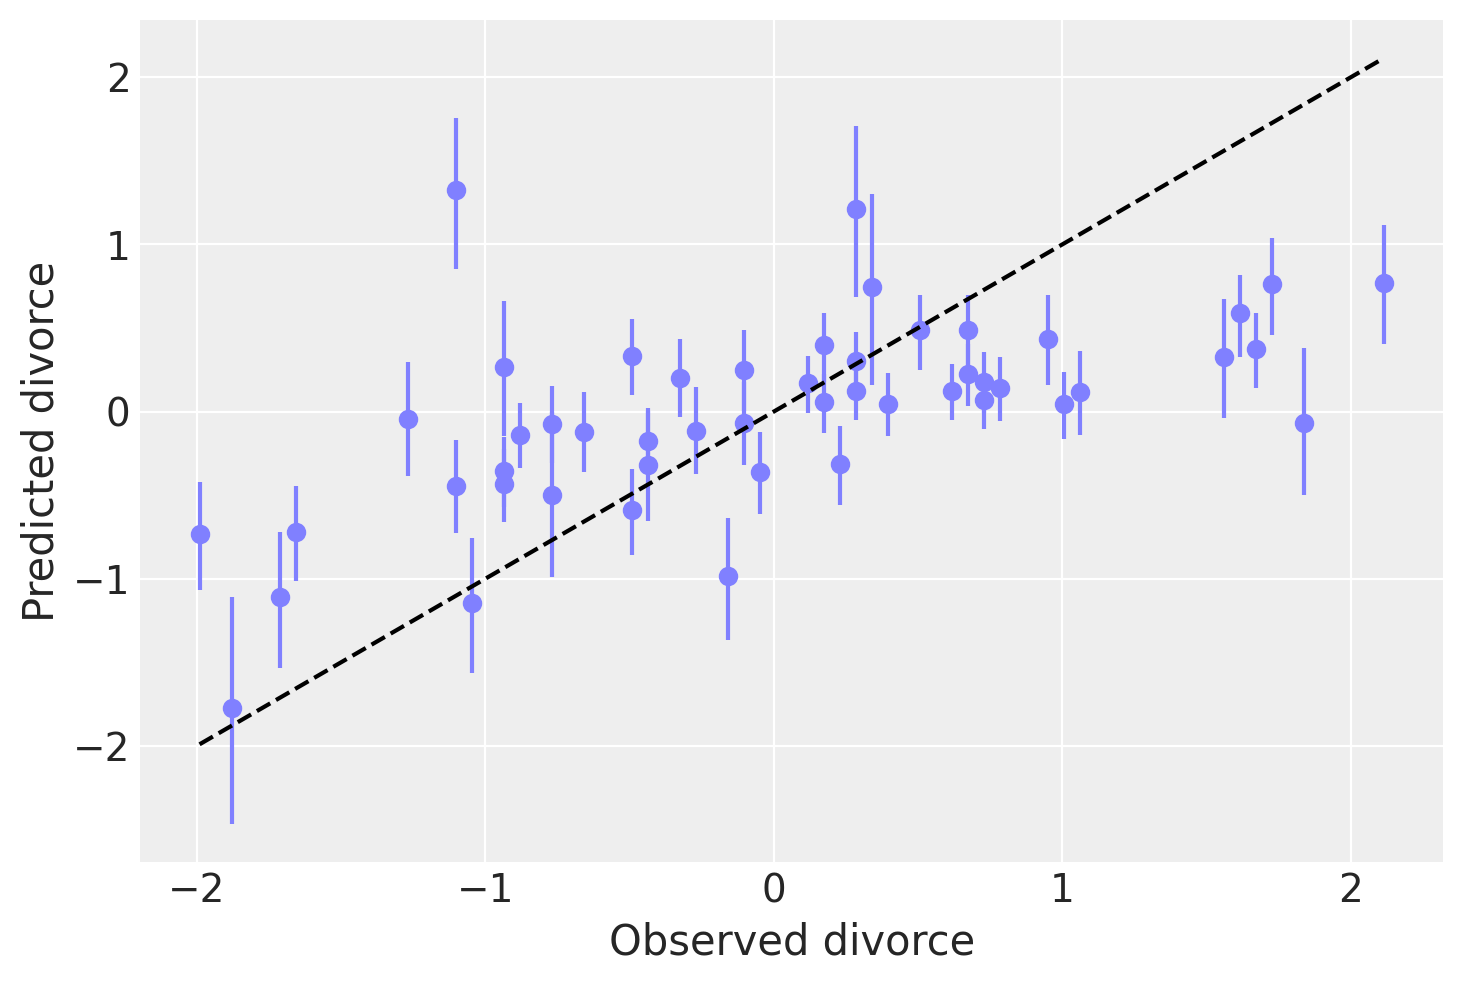

In [96]:
plt.plot(d["D"], mu_mean, "o", c="#8080FF")
# Line with intercept 0 and slope 1
x = [d["D"].min(), d["D"].max()]
plt.plot(x, x, "k--")
plt.vlines(d["D"], ymin=mu_PI[:,0], ymax=mu_PI[:,1], color="#8080FF")
plt.xlabel("Observed divorce")
plt.ylabel("Predicted divorce");

#### Code 5.17

We don't do that here since it is not that easy.

#### Code 5.18

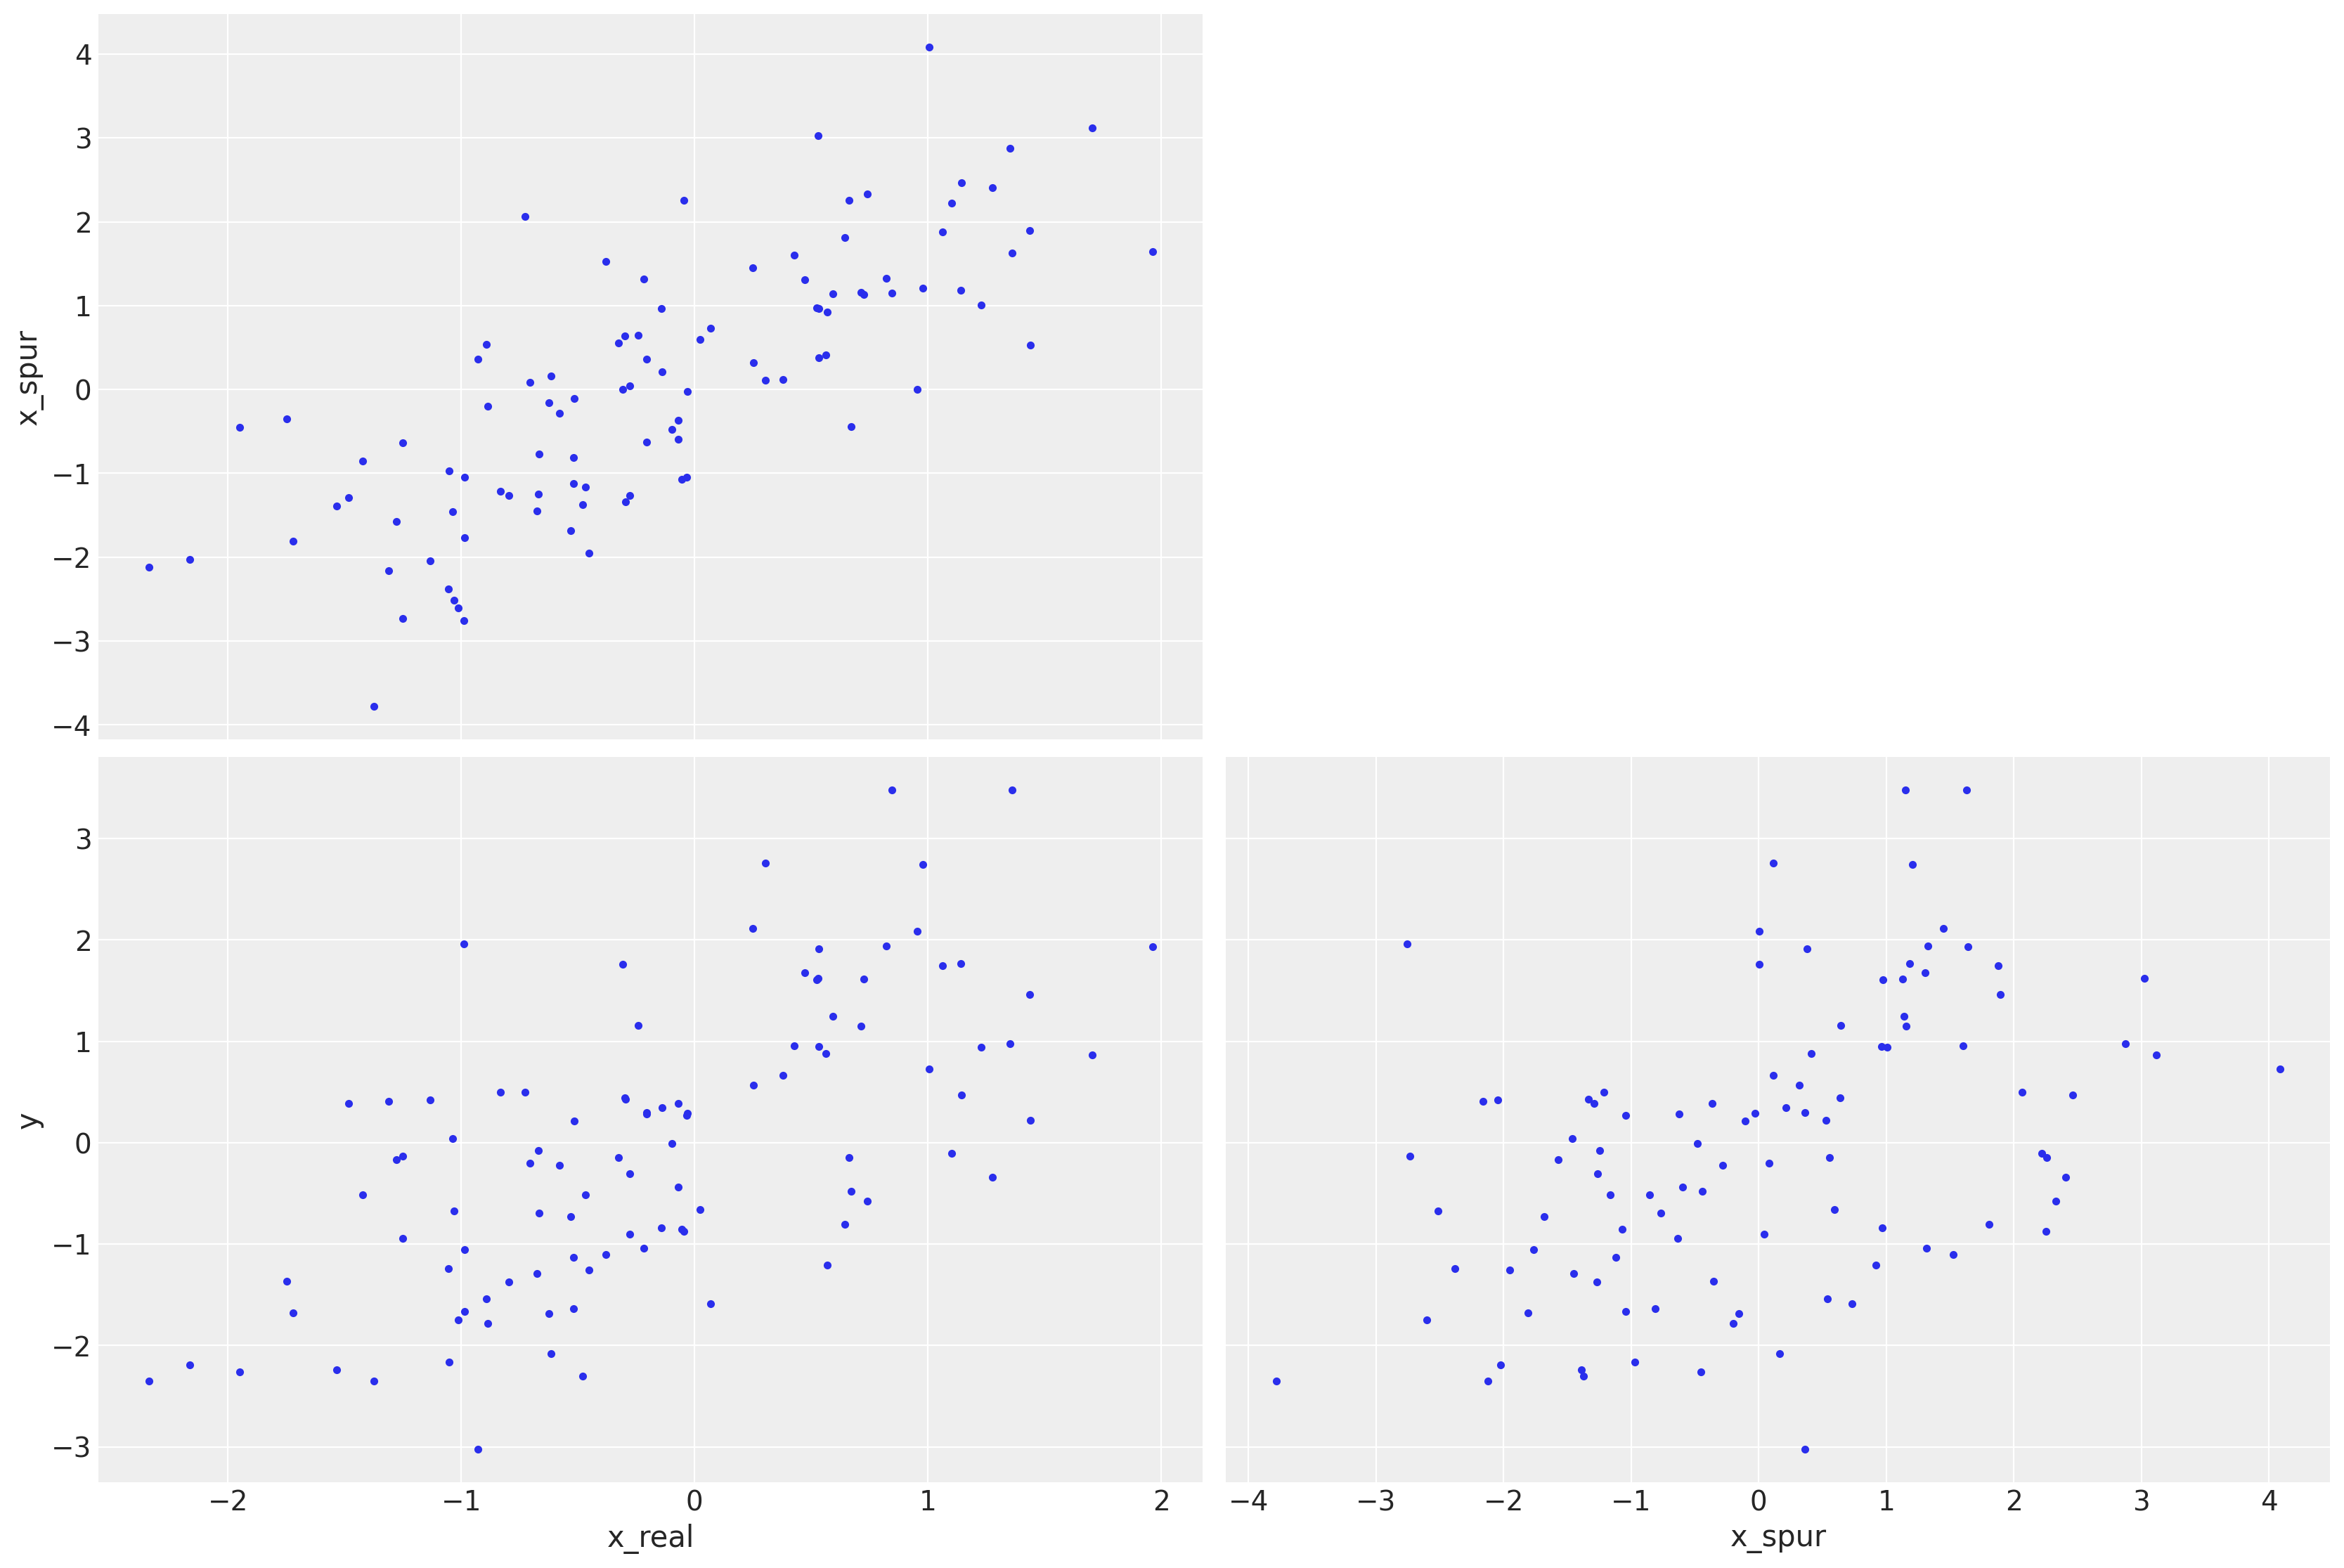

In [97]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

#### Code 5.19
This is a multivariate regression model, which is not supported in Bambi yet.

#### Code 5.20

#### Code 5.21

#### Code 5.22

#### Code 5.23

#### Code 5.24

#### Code 5.25

#### Code 5.26

#### Code 5.27

In [21]:
%watermark -n -u -v -iv -w

Last updated: Wed Apr 21 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

bambi     : 0.4.1
arviz     : 0.11.2
scipy     : 1.6.2
numpy     : 1.20.2
pandas    : 1.2.4
daft      : 0.1.2
matplotlib: 3.4.1

Watermark: 2.2.0

